# Trabajo Qpx — ETL y Análisis

**Enfermedades del corazón (UCI)**

Hecho por: **Alejandro García**


## Contenidos

1. Instalar y usar `ucimlrepo` (cargar dataset desde UCI)
2. Unir X e y en un DataFrame
3. Exploración rápida
4. Limpieza y tratamiento de faltantes (marcados como 'desconocido')
5. Transformaciones y filtros
6. Tabla resumen y guardado
7. Visualizaciones
8. Conclusiones
9. Ejercicio Bonificación


In [2]:
# Instalo la librería oficial para traer datasets desde UCI.
!pip install ucimlrepo --quiet

print('Instalación finalizada.')

Instalación finalizada.


In [3]:
# Traigo el dataset con ucimlrepo (id=45 en UCI)
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# Pido el dataset
print('Traigo el dataset de UCI (id=45)...')
heart_disease = fetch_ucirepo(id=45)

# features (X) y targets (y) vienen en dataframes listos
X = heart_disease.data.features
y = heart_disease.data.targets

# Uno X e y en un solo DataFrame para trabajar cómodo
# Aquí paso los datos como argumentos a pd.concat: primero las tablas, luego axis=1 para unir columnas.
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

print('Carga correctamente completada, Primeras filas:')
df.head()


Traigo el dataset de UCI (id=45)...
Carga correctamente completada, Primeras filas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [4]:
# Miro info que trae ucimlrepo sobre el dataset
# Esto sirve como recordatorio de lo que vimos en clase: revisar origen y variables antes de analizar.
print('Metadata: origen y detalles generales')
print(heart_disease.metadata)

print('Algunas variables (ejemplo)')
for v in heart_disease.variables[:10]:
    print(v)

# Si uno quiere ver todo, puede usar: print(heart_disease.variables)


Metadata: origen y detalles generales
{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R

In [5]:
# Exploración rápida
# Reviso forma, tipos y un resumen. También miro si hay '?' que signifiquen datos faltantes.
print('El dataset tiene (filas, columnas):', df.shape)

print('Tipos de datos por columna:')
print(df.dtypes)

print('Resumen numérico (columnas que son números):')
df.describe().round(2)

print('Chequeo de valores "?": (si aparecen, los marcamos después)')
print((df == '?').sum())


El dataset tiene (filas, columnas): (303, 14)
Tipos de datos por columna:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object
Resumen numérico (columnas que son números):
Chequeo de valores "?": (si aparecen, los marcamos después)
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


### Nota rápida (recordatorio de clase)

En la clase se comento que conviene mirar con atención el objetivo y las columnas antes de sacar conclusiones, Aquí lo dejo como recordatorio suelto en el código, sin cambiar nada todavía interpretare con cuidado los valores del target y las columnas relacionadas cuando haga el análisis.

También, cuando una función tiene argumentos (por ejemplo `pd.read_csv(url, header=None)`), eso le dice a la función exactamente cómo comportarse qué archivo leer y cómo interpretarlo, Más abajo realizo ejemplos donde se uso argumentos para que las funciones hagan lo que quiero.


In [6]:
# Limpieza: marcar desconocido si hay '?' y preparar versión numérica
# Cambio '?' por desconocido para que el informe sea más legible
if (df == '?').any().any():
    df.replace('?', 'desconocido', inplace=True)
    print('Se Reemplazp "?" por desconocido.')
else:
    print('No se encontraron "?" en la tabla, sigue todo bien.')

# Preparo una copia para cálculos donde desconocido pase a NaN (asigno argumentos a to_numeric)
df_num = df.copy()
for c in ['age','trestbps','chol','thalach','oldpeak','ca']:
    if c in df_num.columns:
        # errors='coerce' es un argumento que hace que lo que no sea número quede NaN
        df_num[c] = pd.to_numeric(df_num[c], errors='coerce')

print('Con df_num listo se puedan hacer promedios sin que "desconocido" joda los números.')

# Duplicados
dup = df.duplicated().sum()
print('Filas duplicadas encontradas:', dup)
if dup > 0:
    df = df.drop_duplicates()
    df_num = df_num.drop_duplicates()
    print('Quité duplicados. Nueva forma:', df.shape)


No se encontraron "?" en la tabla, sigue todo bien.
Con df_num listo se puedan hacer promedios sin que "desconocido" joda los números.
Filas duplicadas encontradas: 0


In [8]:
# Transformaciones que ayudan a que la tabla se entienda mejor visualmente

# Agrupo las edades por rangos. Así se ve más claro quiénes son más jóvenes o mayores,
# en lugar de tener un montón de edades sueltas que no dicen mucho a simple vista.
if 'age' in df_num.columns:
    df['edad_grupo'] = pd.cut(
        df_num['age'],
        bins=[0,30,40,50,60,120],
        labels=['<30','30-39','40-49','50-59','60+'],
        right=False
    )
else:
    df['edad_grupo'] = 'desconocido'

# Creo una columna rápida para marcar si alguien podría tener hipertensión.
# Uso la presión en reposo: si pasa de 140 lo tomo como que “sí”.
# No es un diagnóstico real, pero sirve para tener una idea general en el análisis.
if 'trestbps' in df_num.columns:
    df['hipertension_proxy'] = (df_num['trestbps'] > 140).map({
        True: 'sí',
        False: 'no',
        np.nan: 'desconocido'
    })
else:
    df['hipertension_proxy'] = 'desconocido'

print('Agregué edad_grupo e hipertension_proxy para que la información sea más fácil de entender.')
print(df[['age','edad_grupo','trestbps','hipertension_proxy']].head())


Agregué edad_grupo e hipertension_proxy para que la información sea más fácil de entender.
   age edad_grupo  trestbps hipertension_proxy
0   63        60+       145                 sí
1   67        60+       160                 sí
2   67        60+       120                 no
3   37      30-39       130                 no
4   41      40-49       130                 no


In [9]:
# A veces el dataset trae la columna num como nombre del objetivo.
# En clase mencionaron que había que fijarse bien qué significaba esa variable,
# así que la dejo con el nombre target para trabajar más cómodo después.
if 'num' in df.columns:
    df.rename(columns={'num': 'target'}, inplace=True)

# Filtrados pedidos
# Personas mayores de 50 (uso la columna de grupos de edad para no complicarme con cuentas)
mayores_50 = df[df['edad_grupo'].isin(['50-59','60+'])]
print('Pacientes mayores de 50 (aprox):', mayores_50.shape[0])

# Mujeres con hipertensión
mujeres_hip = df[(df['sex'] == 0) & (df['hipertension_proxy'] == 'sí')]
print('Mujeres con hipertensión:', mujeres_hip.shape[0])

# Conteo por edad y target
print('Conteo por edad y target:')
conteo = df.groupby(['edad_grupo', 'target']).size().reset_index(name='cantidad')
conteo



Pacientes mayores de 50 (aprox): 216
Mujeres con hipertensión: 23
Conteo por edad y target:


/tmp/ipython-input-3679152602.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df.groupby(['edad_grupo', 'target']).size().reset_index(name='cantidad')


,edad_grupo,target,cantidad
0,<30,0,1
1,<30,1,0
2,<30,2,0
3,<30,3,0
4,<30,4,0
5,30-39,0,10
6,30-39,1,2
7,30-39,2,0
8,30-39,3,1
9,30-39,4,1


In [10]:
# Armo un resumen por sexo y grupo de edad, para ver cuántos pacientes hay y algunos promedios.
# Uso df directamente porque df_num no tiene la columna de grupo de edad.
resumen = df.groupby(['sex','edad_grupo']).agg(pacientes=('target','count')).reset_index()

# Calculo promedios de edad, colesterol, presión y frecuencia cardíaca
proms = df.groupby(['sex','edad_grupo']).agg(
    edad_media=('age','mean'),
    colesterol_media=('chol','mean'),
    presion_media=('trestbps','mean'),
    frecuencia_media=('thalach','mean')
).round(1).reset_index()

# Junto ambos resultados en una sola tabla
resumen = resumen.merge(proms, on=['sex','edad_grupo'], how='left')

# Muestro el resultado
print('Resumen general por sexo y grupo de edad:')
resumen



Resumen general por sexo y grupo de edad:


/tmp/ipython-input-3714446524.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = df.groupby(['sex','edad_grupo']).agg(pacientes=('target','count')).reset_index()
/tmp/ipython-input-3714446524.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proms = df.groupby(['sex','edad_grupo']).agg(


,sex,edad_grupo,pacientes,edad_media,colesterol_media,presion_media,frecuencia_media
0,0,<30,0,NaN,NaN,NaN,NaN
1,0,30-39,5,36.8,205.4,121.6,175.0
2,0,40-49,19,44.3,234.5,122.8,158.3
3,0,50-59,34,54.6,269.9,135.1,150.9
4,0,60+,39,64.7,275.2,138.4,145.0
5,1,<30,1,29.0,204.0,130.0,202.0
6,1,30-39,9,36.7,227.8,125.8,166.4
7,1,40-49,53,44.4,236.3,124.3,159.6
8,1,50-59,91,55.2,239.0,132.9,147.0
9,1,60+,52,64.6,246.7,135.2,137.1


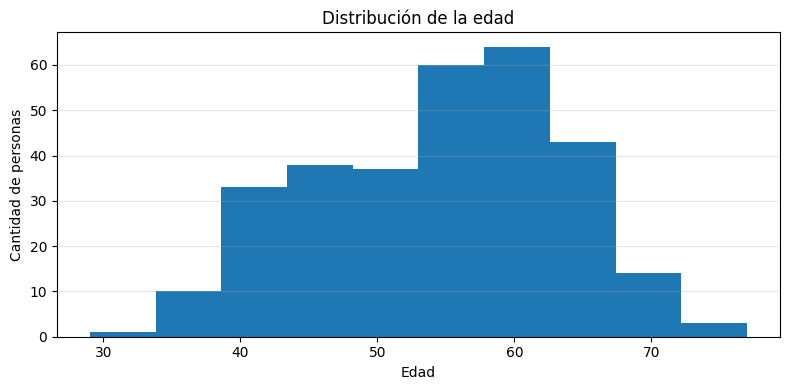

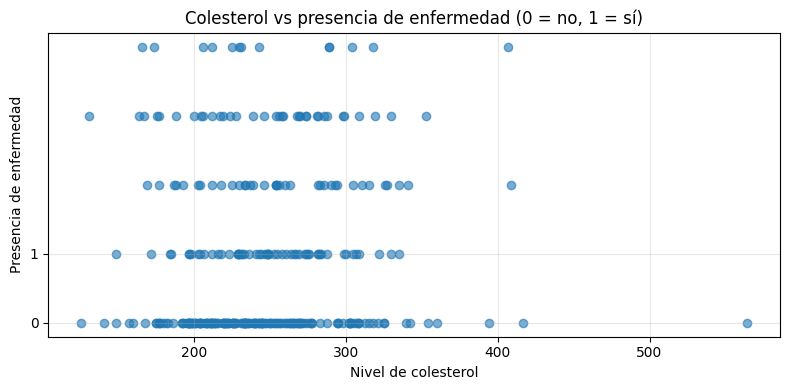

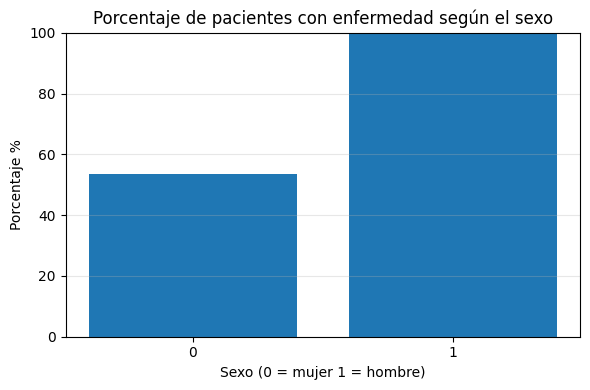



Bueno, con estas gráficas ya se ve más o menos por dónde van los datos.


In [12]:
# Gráficos sencillos para echarle una mirada a los datos y ver si se nota algún patrón o diferencia
import matplotlib.pyplot as plt

# Histograma de la edad (para ver cómo está distribuida)
plt.figure(figsize=(8,4))
if 'age' in df.columns:
    # Acá le paso la columna de edad como argumento, y divido en 10 grupos para que se vea mejor
    plt.hist(df['age'].dropna(), bins=10)
plt.title('Distribución de la edad')
plt.xlabel('Edad')
plt.ylabel('Cantidad de personas')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  # acomoda márgenes dentro del gráfico
plt.show()
print("\n")  # dejo un pequeño espacio visual para que no se vea tan pegado

# Gráfico de dispersión entre colesterol y la presencia de enfermedad
plt.figure(figsize=(8,4))
if 'chol' in df.columns and 'target' in df.columns:
    # Le paso colesterol y target para ver si a mayor colesterol hay más casos de enfermedad
    plt.scatter(df['chol'], df['target'], alpha=0.6)
plt.title('Colesterol vs presencia de enfermedad (0 = no, 1 = sí)')
plt.xlabel('Nivel de colesterol')
plt.ylabel('Presencia de enfermedad')
plt.yticks([0,1])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("\n")  # otro espacio para separar visualmente los gráficos

# Comparo el porcentaje de enfermedad según el sexo
if 'sex' in df.columns and 'target' in df.columns:
    # Agrupo por sexo y saco el promedio del target (como 0 o 1), luego lo paso a porcentaje
    sex_table = df.groupby('sex')['target'].mean().reset_index()
    sex_table['porcentaje_enfermedad'] = (sex_table['target'] * 100).round(1)

    plt.figure(figsize=(6,4))
    plt.bar(sex_table['sex'].astype(str), sex_table['porcentaje_enfermedad'])
    plt.title('Porcentaje de pacientes con enfermedad según el sexo')
    plt.xlabel('Sexo (0 = mujer 1 = hombre)')
    plt.ylabel('Porcentaje %')
    plt.ylim(0,100)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("\n")  # un último espacio para que el cierre no quede apretado

print('Bueno, con estas gráficas ya se ve más o menos por dónde van los datos.')


## Conclusiones

- A simple vista se nota que tanto la edad como el colesterol tienen bastante que ver con la presencia de la enfermedad.
- Decidí crear las columnas `edad_grupo` y `hipertension_proxy` para que todo quedara más entendible y fácil de revisar.
- Los valores marcados como "desconocido" son datos que habría que revisar mejor o confirmar con quien entregó la información.

Sugerencias rápidas:
- Sería bueno que las personas mayores de 50 tengan controles más seguidos o campañas de chequeo.
- Igual esto es solo una mirada general, para tomar decisiones reales se necesitarían más datos y un análisis más completo.



## Ejercicio de bonificación

Este es el ejercicio de bonificación Mantiene la idea original, pero lo ajusté para que el código sea más claro y los mensajes más coherentes,
Simula una pequeña situación donde se manejan vidas, energía y decisiones y casos ilogicos, parecido a un juego sencillo.



In [ ]:
# Ejercicio de bonificación.

# Datos iniciales del jugador
vidas = 10
energia = 100
tiene_espada = True
nivel = 60

# Reviso que los valores tengan algo de sentido antes de arrancar
if energia < 0:
    print('Energía negativa... sí, claro, sos un agujero negro. Dejémosla en 0.')
    energia = 0
if vidas < 0:
    print('Vidas negativas. Ajá, inmortalidad confirmada. Lo dejo en 0 porque no cuela.')
    vidas = 0
if energia > 100:
    print('Energía por encima de 100. Calmate, Gokú. Bajamos a lo permitido.')
    energia = 100
if nivel < 0:
    print('Nivel negativo. Ni el tutorial te quiere así. Lo subo a 1 para que arranques.')

# Casos raros del juego
if not tiene_espada and energia < 20:
    print('Sin espada y sin energía... sí, dale, vas re bien para morir rápido.')

if energia < 10 and vidas > 5:
    print('Tenés un montón de vidas pero ni fuerza para moverte. Muy útil, sí.')

if energia > 50 and vidas == 0:
    print('Mucha energía para alguien muerto. Claramente el sistema está roto.')

# Sugerencias según el nivel de energía
if 30 <= energia <= 60:
    print('Energía media, ni mal ni bien. Pero andá pensando en una poción.')
elif energia < 30:
    print('Tenés menos energía que mi celular a las 11 de la noche. Cargate o fuiste.')

# Si no hay vidas
if vidas == 0:
    print('Sin vidas. O te rendís o esperás que el milagro del respawn te salve.')

# Lógica del jefe final (Radahn personaje de uno de mis juegos souls favoritos elden ring)
if vidas > 0:
    if tiene_espada and energia >= 70 and nivel > 35:
        print('Tenés todo listo, crack. Ahora andá y morí con dignidad contra Radahn.')
    elif tiene_espada and energia >= 70 and nivel <= 35:
        print('Buena energía y espada, pero con ese nivel... te van a borrar del mapa.')
    elif tiene_espada and energia < 70 and nivel > 35:
        print('Buen nivel, pero estás medio fundido. Tomate una poción o te deja en el piso.')
    elif not tiene_espada and energia >= 70 and nivel > 35:
        print('Tenés buena energía y nivel, pero sin espada? vas a pegarle con la mirada?')
    elif not tiene_espada and energia < 70 and nivel < 35:
        print('Sin arma, sin energía, sin nivel... solo te falta perder la dignidad.')
    else:
        print('Claramente no estás listo, pero si querés sufrir, adelante.')
else:
    print('Querés pelear sin vidas? bueno, técnicamente ya sos un fantasma, así que andá tranqui.')

# Estado final del jugador
print('Estado final — vidas:', vidas, '| energía:', energia, '| nivel:', nivel)

Tenés todo listo, crack. Ahora andá y morí con dignidad contra Radahn.
Estado final — vidas: 10 | energía: 100 | nivel: 60


# Nota final:
# Proyecto terminado con todo lo que se pedía: datos limpios, análisis, gráficos y el ejercicio extra.
# Todo revisado paso a paso y con lógica clara, aunque sinceramente el dataset dio más pelea que Radahn.

